# Abstract

This project explores the association between state-level gun law strength and firearm mortality in the United States for 2023. Using publicly available mortality data and a 0–100 gun-law strength index, I merged, cleaned, and standardized the data for the 50 states (plus D.C. when available). I then created law-strength quintiles (“Very low” to “Very high”) and summarized firearm deaths (including homicides and suicides) per 100,000 population (crude rates) within and across those groups. 



In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from functools import reduce


Introduction

Firearm mortality varies widely across U.S. states. Policymakers, researchers, and the public routinely ask whether differences in state gun policies are associated with differences in firearm deaths. This project evaluates that question descriptively for 2023 by combining:

* Firearm mortality (crude deaths per 100,000 residents) at the state level.

* Gun-law strength summarized as a 0–100 index from a public policy source (the dataset you used labels it “Strength of Gun Laws (out of 100 points)”).
    Note: The index aggregates the presence/absence or design of multiple policies into one score; it does not measure enforcement or cultural context.

The core research question is deliberately narrow and skeptical:

*How do state firearm death rates relate to a law-strength index, and do patterns remain when we group states into quintiles of law strength?*

I emphasize patterns, not causes. States differ on many dimensions (age structure, urbanization, income, regional culture, firearm ownership, substance use, suicide prevalence), and those factors can confound simple comparisons. Also, some states' death rates can be affected by neighboring states laws strengths.

In [2]:
cdc_df = pd.read_csv('https://raw.githubusercontent.com/farhodibr/CUNY-SPS-MSDS/refs/heads/main/DATA608/PROJECT3/Multiple%20Cause%20of%20Death%2C%202018-2023%2C%20Single%20Race.csv')
law_rate_df = pd.read_csv('https://raw.githubusercontent.com/farhodibr/CUNY-SPS-MSDS/refs/heads/main/DATA608/PROJECT3/Everytown-gun-laws-save-lives%20(1).csv')

In [3]:
display(cdc_df)

,Notes,State,State Code,Year,Year Code,Deaths,Population,Crude Rate
0,NaN,Alabama,1.0,2022.0,2022.0,1238.0,5074296.0,24.4
1,NaN,Alabama,1.0,2023.0,2023.0,1251.0,5108468.0,24.5
2,Total,Alabama,1.0,NaN,NaN,2489.0,10182764.0,24.4
3,NaN,Alaska,2.0,2022.0,2022.0,155.0,733583.0,21.1
4,NaN,Alaska,2.0,2023.0,2023.0,167.0,733406.0,22.8
...,...,...,...,...,...,...,...,...
212,"a result, users should consider that the actua...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,"deaths, with a crude rate of approximately 41....",NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,"100,000 population. These deaths will not be u...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,6. Changes to cause of death classification af...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
cdc_keep_cols = ['State', 'Year', 'Deaths', 'Population', 'Crude Rate']
mask = (
    cdc_df.State.notna() & cdc_df.Year.notna()
)

cdc_df_clean = cdc_df.loc[mask, cdc_keep_cols].copy()
cdc_df_clean = cdc_df_clean.rename(
    columns={'State': 'state', 'Year': 'year', 'Deaths': 'deaths', 'Population': 'population', 'Crude Rate': 'crude_rate'})
numeric_cols = ["year", "deaths", "population"]

cdc_df_clean[numeric_cols] = (
    cdc_df_clean[numeric_cols]
      .apply(pd.to_numeric, errors="coerce")
      .round()
      .astype("Int64")         
)
display(cdc_df_clean)

,state,year,deaths,population,crude_rate
0,Alabama,2022,1238,5074296,24.4
1,Alabama,2023,1251,5108468,24.5
3,Alaska,2022,155,733583,21.1
4,Alaska,2023,167,733406,22.8
6,Arizona,2022,1472,7359197,20.0
...,...,...,...,...,...
145,West Virginia,2023,306,1770071,17.3
147,Wisconsin,2022,806,5892539,13.7
148,Wisconsin,2023,738,5910955,12.5
150,Wyoming,2022,118,581381,20.3


In [5]:
law_rate_df.head()

,Series,Label,laws_strength,"Gun Deaths per 100,000 Residents"
0,State,AL,12.0,25.6
1,State,AK,9.0,23.5
2,State,AZ,7.5,18.5
3,State,AR,4.5,21.9
4,State,CA,90.5,8.0


In [6]:
law_rate_keep_cols = ["Label", "laws_strength"]

mask = (
    law_rate_df["Label"].notna()
    & law_rate_df["laws_strength"].notna()
)

law_rate_df = law_rate_df.loc[mask, law_rate_keep_cols].copy()
law_rate_df = law_rate_df.rename(columns={'Label': 'state_abb'})

state_map = {
    "AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California",
    "CO":"Colorado","CT":"Connecticut","DE":"Delaware", "District of Columbia":"DC", "FL":"Florida","GA":"Georgia",
    "HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa",
    "KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland",
    "MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri",
    "MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey",
    "NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio",
    "OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina",
    "SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont",
    "VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming",
    "DC":"District of Columbia"
}

law_rate_df['state'] = (
    law_rate_df["state_abb"].astype(str).str.strip().str.upper().map(state_map)
)

col = 'state'
law_rate_df = law_rate_df[[col] + [c for c in law_rate_df.columns if c != col]]
law_rate_df.head()

,state,state_abb,laws_strength
0,Alabama,AL,12.0
1,Alaska,AK,9.0
2,Arizona,AZ,7.5
3,Arkansas,AR,4.5
4,California,CA,90.5


In [7]:
cdc_2023 = cdc_df_clean[cdc_df_clean.year == 2023].copy()
cdc_2022 = cdc_df_clean[cdc_df_clean.year == 2022].copy()
cdc_2023.head()
cdc_2022.head()

,state,year,deaths,population,crude_rate
0,Alabama,2022,1238,5074296,24.4
3,Alaska,2022,155,733583,21.1
6,Arizona,2022,1472,7359197,20.0
9,Arkansas,2022,631,3045637,20.7
12,California,2022,3365,39029342,8.6


In [8]:
analysis_df = pd.merge(cdc_2023, law_rate_df, on='state', how='left')
analysis_df.head()

,state,year,deaths,population,crude_rate,state_abb,laws_strength
0,Alabama,2023,1251,5108468,24.5,AL,12.0
1,Alaska,2023,167,733406,22.8,AK,9.0
2,Arizona,2023,1361,7431344,18.3,AZ,7.5
3,Arkansas,2023,659,3067732,21.5,AR,4.5
4,California,2023,3074,38965193,7.9,CA,90.5


In [57]:
total_deaths_2023 = analysis_df.deaths.sum()
total_deaths_2022 = cdc_2022.deaths.sum()
print(total_deaths_2023)
line1 = 'total amount of '
emph = 'fatalities caused by '
emph2 = 'guns and firearms in US'
line2 = 'in 2023 according to CDC data'

total_color = "#2B7C84"   
text_color = "#9aa0a6"  
emph_color = "#2B7C84" 



45227


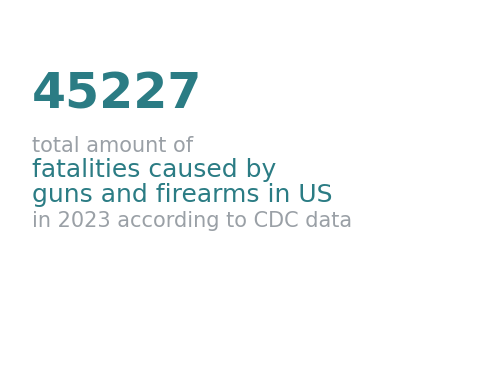

In [65]:
fig = plt.figure(dpi=75)
ax = plt.axes([0,0,1,1])   # full-bleed axes
ax.axis("off")

# --- your texts ---
t1 = plt.text(0.05, 0.72, str(total_deaths_2023),
              fontsize=47, weight='bold', color=total_color, family='DejaVu Sans')
t2 = plt.text(0.05, 0.60, line1,
              fontsize=20, color=text_color, family='DejaVu Sans')
t3 = plt.text(0.05, 0.53, emph,
              fontsize=24, color=emph_color, family='DejaVu Sans')
t4 = plt.text(0.05, 0.46, emph2,
              fontsize=24, color=emph_color, family='DejaVu Sans')
t5 = plt.text(0.05, 0.39, line2,
              fontsize=20, color=text_color, family='DejaVu Sans')

# --- compute tight bbox around all texts ---
fig.canvas.draw()
arts   = [t1, t2, t3, t4, t5]
bboxes = [a.get_window_extent(fig.canvas.get_renderer()) for a in arts]

# union ALL bboxes in one call
bb_px = Bbox.union(bboxes)   # <- this returns one Bbox in pixels

# expand a little and convert to inches
pad_px = 12
bb_px = Bbox.from_extents(bb_px.x0 - pad_px, bb_px.y0 - pad_px,
                          bb_px.x1 + pad_px, bb_px.y1 + pad_px)
bb_in = bb_px.transformed(fig.dpi_scale_trans.inverted())

fig.savefig("card.png", bbox_inches=bb_in, transparent=True)
plt.show()

## 45,227 deaths—more than a mid-size city.
What concrete steps would meaningfully bend this number down?

In [9]:
x = pd.to_numeric(analysis_df.laws_strength, errors='coerce')
y = pd.to_numeric(analysis_df.crude_rate, errors='coerce')
w= pd.to_numeric(analysis_df.population, errors='coerce')

mask= x.notna() & y.notna() & w.notna() & (w >0)

xw, yw, ww = x[mask].to_numpy(), y[mask].to_numpy(), w[mask].to_numpy()

mx = np.average(xw, weights=ww)

my= np.average(yw, weights=ww)

cov_num = np.sum(ww*(xw - mx)*(yw - my))

varx_num = np.sum(ww*(xw - mx)**2)
vary_num = np.sum(ww*(yw - my)**2)

den = np.sqrt(varx_num * vary_num)
r_w = cov_num / den if den !=0 else np.nan

print(f"Weighted Pearson r (laws_strength vs crude_rate): {r_w:.3f}")



Weighted Pearson r (laws_strength vs crude_rate): -0.774


## Laws versus Firearm Death Rate

In [10]:
cols = ["state","state_abb","year","deaths","population","laws_strength","crude_rate"]
d = analysis_df.loc[mask, cols].copy()

flg = px.scatter(
    d,
    x= cols[5], y=cols[6],
    size=cols[4], size_max=42,
    hover_name=cols[0],
    hover_data={cols[1]: True, cols[2]: True, cols[3]: ':,', cols[4]: ':, '},
    labels={cols[5]: 'Law strength (0 - 100)', cols[6]: 'Firearm deaths per 100K'},
    width=1400, height=750
)

flg.update_layout(
    title=f"Laws vs Firearm Death Rate — size ∝ population (weighted r = {r_w:.2f})",
    template= None,
    font=dict(color='gray'),
    title_font_color='gray',)
    #legend=dict(font=dict(color='gray')))

flg.update_xaxes(color='gray', showline=True, linecolor='gray',
                 gridcolor=None, zerolinecolor="#e6e6e6")
flg.update_yaxes(color='gray', showline=True, linecolor='gray',
                 gridcolor=None, zerolinecolor="#e6e6e6")
slope, intercept = np.polyfit(xw, yw, deg=1, w=ww)
x_line = np.linspace(xw.min(), xw.max(), 200)
y_line = slope*x_line + intercept
flg.add_trace(go.Scatter(x=x_line, y=y_line, mode='lines', name='WLS fit'))
flg.show()


Population-weighted scatter of state gun-law strength vs. firearm mortality (2023): larger bubbles are larger states. The weighted fit (r = −0.77) indicates a strong negative association: stronger laws correlate with fewer deaths per 100k.

In [11]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Gun laws strength', 'Gun death rate per 100K'),
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]],
    horizontal_spacing=0.005
)

fig.add_trace(go.Choropleth(
    locations=d.state_abb,
    z=d.laws_strength,
    locationmode="USA-states",
    colorscale='Blues',
    zmin=0, zmax=100,
    coloraxis="coloraxis", 
    customdata=np.stack([d.state, d.laws_strength], axis=1),
    hovertemplate='<b>%{customdata[0]} </b><br>Strength of laws: %{customdata[1]:.1f}'
), row=1, col=1)

zmin = float(d.crude_rate.min())
zmax = float(d.crude_rate.max())


fig.add_trace(go.Choropleth(
    locations=d.state_abb,
    z=d.crude_rate,
    locationmode="USA-states",
    colorscale='Greys',
    zmin=zmin, zmax=zmax,
    coloraxis="coloraxis2", 
    customdata=np.stack([d.state, d.crude_rate, d.population], axis=1),
    hovertemplate='<b>%{customdata[0]} </b><br>Deaths per 100K: %{customdata[1]:.1f}</b><br>Population: %{customdata[2]:.1f} '
), row=1, col=2)

fig.update_geos(scope='usa', projection_type='albers usa', row=1,col=1)
fig.update_geos(scope='usa', projection_type='albers usa', row=1,col=2)

fig.update_layout(
     title=dict(
        text="Gun Laws Strength versus Gun Death Rate per 100K — 2023",
        font=dict(size=24),      
        x=0.5, xanchor="center"
    ),
    width = 1400, height=550,
    template=None,
    #paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color="#6e6e6e")
)

PALETTE = ["#fff5eb", "#fae2ca", "#edc297", "#eda566", "#ef6a32"]
def discrete_colorscale(colors):
    n = len(colors)
    stops = []
    for i, c in enumerate(colors):
        a = i / n
        b = (i + 1) / n
        stops.append([a, c]); stops.append([b, c])
    return stops

cs = discrete_colorscale(PALETTE)

fig.update_layout(

    coloraxis=dict(
        colorscale="Blues", cmin=0, cmax=100,
        colorbar=dict(
            orientation="h", y=-0.10, x=0.25, xanchor="center",
            len=0.40, thickness=20, title="Laws Strength"
        )
    ),
    coloraxis2=dict(
        colorscale=cs, cmin=zmin, cmax=zmax,
        colorbar=dict(
            orientation="h", y=-0.10, x=0.75, xanchor="center",
            len=0.40, thickness=20, title="Deaths per 100k"
        )
    )
)

fig.show(config={"scrollZoom": False})

Two-map view (2023): 

Stronger gun-law states cluster in the Northeast and West Coast (especially California) and typically have lower firearm death rates; weaker-law states in the South (LA, MS and AL) and parts of the Mountain West show higher rates. 

A few low-strength states (New Hampshire, Wiconsin) still display low mortality, and the reason can be adjacent to strong-law neighbors — suggesting possible regional spillovers. 

In [ ]:
#d.head()

In [13]:
d[["year","laws_strength","crude_rate","population"]] = (
    d[["year","laws_strength","crude_rate","population"]].apply(pd.to_numeric, errors="coerce")
)
d = d.loc[d["year"] == 2023].dropna(subset=["state_abb","laws_strength","crude_rate"]).copy()

labels = ["Very low", "Low", "Moderate", "High", "Very high"]
d["tier"] = pd.qcut(d["laws_strength"], q=5, labels=labels, duplicates="drop")

rate_codes, rate_bins = pd.qcut(
    d["crude_rate"], q=5, labels=False, retbins=True, duplicates="drop"
)
d["rate_bin"] = (rate_codes + 1).astype(int)

In [14]:
fig = make_subplots(
    rows=len(labels), cols=1,
    specs=[[{"type": "heatmap"}]] * len(labels),
    subplot_titles=labels,
    vertical_spacing=0.06
)

def discrete_colorscale(colors):
    n = len(colors)
    stops = []
    for i, c in enumerate(colors):
        a = i / n
        b = (i + 1) / n
        stops.append([a, c]); stops.append([b, c])
    return stops

In [15]:
for r, tier in enumerate(labels, start=1):
    t = (
        d.loc[d["tier"] == tier]
         .sort_values(["crude_rate", "state_abb"], ascending=[True, True])
    )
    z   = np.array([t["rate_bin"].astype(float).values])
    txt = np.array([np.char.mod('%.1f', t["crude_rate"].values)])
    hovertext = np.array([np.char.mod('%.1f', t["laws_strength"].to_numpy())])  

    fig.add_trace(go.Heatmap(
        z=z,
        x=t["state_abb"].tolist(), y=[tier],
        coloraxis="coloraxis",
        text=txt, texttemplate="<b>%{text}</b>", textfont={"color":"black","size":12},
        hovertext=hovertext,
        hovertemplate=(
            "<b>%{y}</b> — %{x}<br>"
            "Deaths per100k: %{text}<br>"
            "Laws strength: %{hovertext}<extra></extra>"
        ),
        zmin=1, zmax=5
    ), row=r, col=1
)

    fig.update_xaxes(row=r, col=1, tickangle=0, showgrid=False, zeroline=False, showline=False)

In [16]:
tickvals = [1, 2, 3, 4, 5]
fmt = lambda v: f"{v:.1f}"
ticktext = [
    f" ≤{fmt(rate_bins[1])}",
    f"{fmt(rate_bins[1])}–{fmt(rate_bins[2])}",
    f"{fmt(rate_bins[2])}–{fmt(rate_bins[3])}",
    f"{fmt(rate_bins[3])}–{fmt(rate_bins[4])}",
    f"≥{fmt(rate_bins[4])}",
]



fig.update_layout(
    coloraxis=dict(
        colorscale=cs, cmin=1, cmax=5,
        colorbar=dict(
            orientation="h", y=-0.18, x=0.5, xanchor="center",
            len=0.60, thickness=12, title="Deaths/100k",
            tickmode="array", tickvals=tickvals, ticktext=ticktext, outlinewidth=0
        )
    ),
    template="simple_white",
    width=1400, height=620,
    title=dict(text="Firearm Mortality by Law-Strength Categories — 2023",
               x=0.5, xanchor="center"),
    font=dict(family="Inter, Arial, sans-serif", size=14, color="#807c7c"),
   
    margin=dict(l=130, r=20, t=80, b=110)
)

for r in range(1, len(labels) + 1):
    fig.update_yaxes(row=r, col=1, showticklabels=False, showgrid=False, zeroline=False, showline=False)
fig.update_traces(selector=dict(type="heatmap"), xgap=4, ygap=12)

for i in range(len(labels)):
    dom = fig.layout[f"yaxis{i+1}"].domain
    fig.layout.annotations[i].update(
        x=-0.02, y=(dom[0] + dom[1]) / 2, xanchor="right", yanchor="middle",
        font=dict(size=14, color="#4c4c4c")
    )

for r in range(1, len(labels) + 1):
    fig.update_xaxes(
        row=r, col=1,
        showticklabels=False,   
        ticks="",              
        ticklen=0,
        tickvals=[]             
    )

fig.update_layout(margin=dict(b=60))

fig.update_layout(margin=dict(l=170))

fig.add_annotation(
    xref="paper", yref="paper",
    x=-0.10, y=0.5, showarrow=False,
    text="Laws strength categories",
    textangle=-90,
    font=dict(size=18, color="#4c4c4c")
)

fig.update_layout(margin=dict(t=110))
fig.add_annotation(
    xref="paper", yref="paper", x=0.45, y=1.1, showarrow=False,
    text="color: deaths per 100k population (darker = higher rates, lighter = lower rates) · rows: law-strength categories (2023)",
    align="center", font=dict(size=13, color="#6e6e6e")
)


fig.show()

This hetmap clearly shows that stricter gun laws has an effect on death rates compared to states with relaxed laws and regulations.

Each row is a quintile of the gun-law strength index (Very low → Very high). Each tile is a state; color = firearm deaths per 100k (darker = higher), with the value printed on the tile.

## Average law strenghes VS Average deat rates for each group

In [98]:
d = analysis_df.copy()
d[["year","laws_strength","crude_rate"]] = d[["year","laws_strength","crude_rate"]].apply(pd.to_numeric, errors="coerce")
d = d.loc[d["year"]==2023, ["state_abb","laws_strength","crude_rate"]].dropna()

labels = ["Very high","High","Moderate","Low","Very low"]  
d["tier"] = pd.qcut(d["laws_strength"], q=5, labels=labels, duplicates="drop")

g = (d.groupby("tier", observed=True)
       .agg(avg_strength=("laws_strength","mean"),
            avg_deaths=("crude_rate","mean"),
            n=("state_abb","count"))
       .reset_index())

cat = pd.CategoricalDtype(categories=labels, ordered=True)
g["tier"] = g["tier"].astype(cat)
g = g.sort_values("tier")

name_map = {
    "Very high":"National Failures",
    "High":"Weak Systems",
    "Moderate":"Missing Key Laws",
    "Low":"Making Progress",
    "Very low":"National Leaders",
}


g["display"] = g["tier"].map(name_map)

s_min, s_max = g["avg_strength"].min(), g["avg_strength"].max()
blue_len = (g["avg_strength"] - s_min) / (s_max - s_min + 1e-9)

d_min, d_max = g["avg_deaths"].min(), g["avg_deaths"].max()
red_len = (g["avg_deaths"] - d_min) / (d_max - d_min + 1e-9)

track = np.ones(len(g))

fig = go.Figure()

n = len(g)
fig.add_bar(
    y=g["display"], x=2*np.ones(n), base=-1, orientation="h",
    marker=dict(color="#ebf0fa"), hoverinfo="skip", showlegend=False,
    offsetgroup=0
)

fig.add_bar(
    y=g["display"], x=-blue_len, orientation="h",
    marker=dict(color="#3b6df6"), opacity=0.9,
    name="Avg law strength (scaled)",
    hovertemplate="%{y}<br>Avg law strength: %{customdata:.1f}<extra></extra>",
    customdata=g["avg_strength"],
    offsetgroup=0
)

fig.add_bar(
    y=g["display"], x=red_len, orientation="h",
    marker=dict(color="#e34234"), opacity=0.9,
    name="Avg deaths/100k (scaled)",
    hovertemplate="%{y}<br>Avg deaths/100k: %{customdata:.1f}<extra></extra>",
    customdata=g["avg_deaths"],
    offsetgroup=1 
)


fig.update_layout(
    barmode="overlay", bargap=0.45, template="simple_white",
    width=1000, height=420, showlegend=False,
    title=dict(
        text=("Strong Gun Laws, Fewer Deaths"
              "<br><span style='font-size:0.9em; font-weight:400; color:#6e6e6e;'>"
              "Blue bars extend left showing average law strength "
              "<br>Red bars extend right showing avg deaths per 100k"
              "<br>  "
              "</span>"),
        x=0.03, xanchor="left"
    ),
    margin=dict(l=240, r=30, t=80, b=80)  
)

fig.update_xaxes(visible=False, range=[-1.05, 1.05], fixedrange=True,
                 showline=False, mirror=False, showgrid=False, zeroline=False)

fig.update_yaxes(showline=False, mirror=False, showgrid=False, zeroline=False)

fig.update_layout(plot_bgcolor="white")
fig.add_vline(x=0, line_color="#bdbdbd", line_width=2, opacity=0.9)

pad = 0.02



for y, blen, rlen, sval, dval in zip(
        g["display"], blue_len, red_len, g["avg_strength"], g["avg_deaths"]):

    fig.add_annotation(
        x=-(blen + pad), y=y, xref="x", yref="y",
        text=f"{sval:.0f}", showarrow=False,
        xanchor="right", yanchor="middle",
        font=dict(color="#3b6df6", size=11)
    )

    # Red label (to the right of the red bar end)
    fig.add_annotation(
        x=(rlen + pad), y=y, xref="x", yref="y",
        text=f"{dval:.1f}", showarrow=False,
        xanchor="left", yanchor="middle",
        font=dict(color="#e34234", size=11)
    )

    

fig.update_layout(width=1400, height=520, margin=dict(l=240, r=30, t=80, b=30))
fig.update_xaxes(visible=False, range=[-1.15, 1.15], fixedrange=True)
#fig.update_yaxes(visible=False)

fig.show()


States in stronger law tiers average lower firearm death rates; as law strength falls from “National Leaders” to “National Failures,” deaths rise from ~8.6 to ~19.6 per 100k. It’s a strong indicator that gun laws and regulations have an effect on death rates caused by guns.

## Conclusion
Across every analysis I made, the story is consistent: states grouped into stronger law tiers have materially lower firearm death rates, and the gap is big - roughly 8–10 deaths per 100k in the strongest tier versus ~20 per 100k in the weakest. This fact is hard to ignore. Still, this is an association, built on an index and a single year; it could be shaped by ownership prevalence, suicide vs. homicide mix, urbanization, poverty, policing, trafficking from neighboring states, or simple policy lag (stronger laws may take time to bite). 

To see if these facts are real, next things I would do: 
* run population-weighted models with controls for ownership numbers, income, education, urban share, and region (also drug and alcohol addictions can play as a factors); 
* add trafficking factors from neighboring states and states bordering with Mexico features (weak-law neighbors); 
* split outcomes into homicide vs. suicide; 
* do a multi-year panel to capture before/after changes when states gun laws and regulations; 


The current evidence points in one direction — stronger laws align with fewer deaths.